In [1]:
import sys
sys.path.append('..')

from tqdm import tqdm
import webbrowser
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

from src.pingers import *
from src.models import *
from src import crud
from src.utils import *
from src.fb_api.get_preview_shareable_link import get_preview_shareable_link
from src.models.enums import TextType, CreativeType
from src.database.session import db
metrics = (cr, ctr, cpm, roas)
df_path = '/app/data/black_friday_2022.csv'

2023-10-19 11:58:08.943 | DEBUG    | src.database.session:<module>:17 - base: prod.cw6tznt1p9hq.us-east-1.rds.amazonaws.com


In [2]:
def get_discounts(text: str) -> list:
    discounts = []
    discounts.extend([x.group() for x in re.finditer(r"(?i)(discount)\s(of\s)?()[\d]+\s?%", text)])
    discounts.extend([x.group() for x in re.finditer(r"(?i)(save)\s[\d]+\s?%", text)])
    discounts.extend([x.group() for x in re.finditer(r"(?i)[\d]+\s?%\s?(off)", text)])
    discounts.extend([x.group() for x in re.finditer(r"(?i)[\d]+\s?%\s(discount)", text)])
    discounts.extend([x.group() for x in re.finditer(r"(?i)-[\d]+\s?%", text)])
    return discounts

In [3]:
df = read_csv_and_eval(df_path)
df = df[(df.CR < 10) & (df.creative_type != CreativeType.unknown)]

In [14]:
df['countries'] = df.targeting.apply(lambda d: d.get('geo_locations', {}).get('countries', []))
US_df = df[(df.countries.apply(len) == 1)]
US_df = US_df[(US_df.countries.apply(lambda l: l[0] == 'US'))]

In [16]:
len(US_df)

348

In [8]:
df.targeting[2]['geo_locations']['countries']

{'countries': ['US'], 'location_types': ['home', 'recent']}

In [4]:
access_tokens_dict = {
    shop_id: access_token
    for shop_id in df.shop_id.unique().tolist()
    if (access_token := crud.credentials.get_facebook_access_token_by_shop(db=db, shop_id=shop_id))
    is not None
}
top_df = df[df.shop_id.isin(access_tokens_dict.keys())]
top_df = (
    top_df.groupby("shop_id")
    .apply(lambda df: df.loc[df.CPM.idxmax(), :])
    .sort_values("CPM")
    .reset_index(drop=True)
    .loc[:30, :]
)
# top_df["preview_link"] = top_df.apply(
#     lambda row: get_preview_shareable_link(ad_id=row.ad_id, access_token=access_tokens_dict[row.shop_id]), axis=1
# )
# for link in top_df.preview_link:
#     webbrowser.open(link)
# video_df = df[df.creative_type == CreativeType.video]
# df = df[df.shop_id.isin(video_df.shop_id.unique().tolist())]

In [5]:
df.creative_type.value_counts()

creative_type
dynamic     299
carousel    214
image        53
video        41
Name: count, dtype: int64

In [6]:
df.shop_id.nunique()

125

<Axes: xlabel='creative_type', ylabel='CTR'>

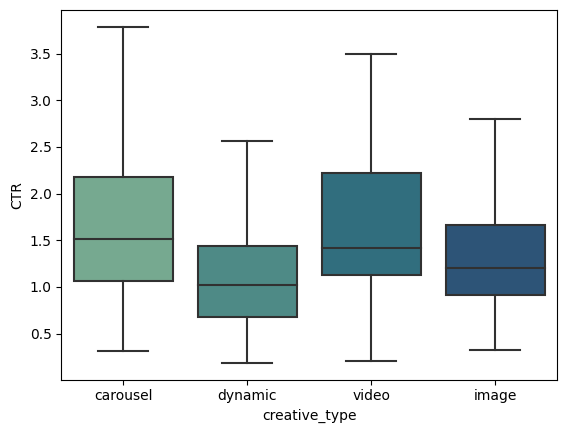

In [39]:
sns.boxplot(data=df, x='creative_type', y='CTR', palette='crest', showfliers=False)

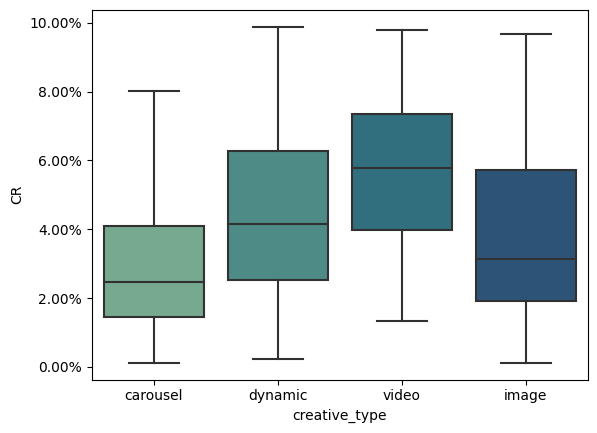

In [7]:
metric = cr
g = sns.boxplot(data=df, x='creative_type', y=str(metric), palette='crest', showfliers=False)
g.yaxis.set_major_formatter(ticker.FuncFormatter(metric.format))

<Axes: xlabel='creative_type', ylabel='CPM'>

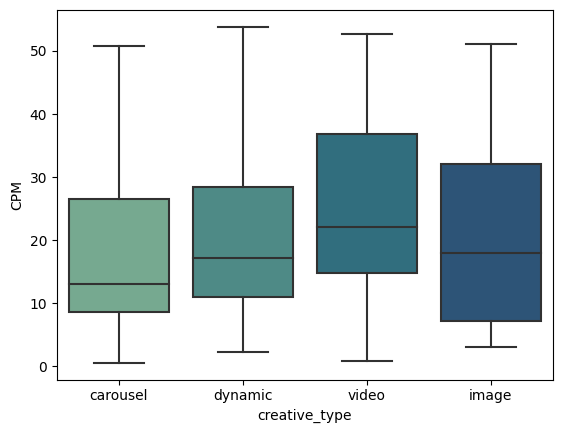

In [41]:
sns.boxplot(data=df, x='creative_type', y='CPM', palette='crest', showfliers=False)

<Axes: xlabel='creative_type', ylabel='ROAS'>

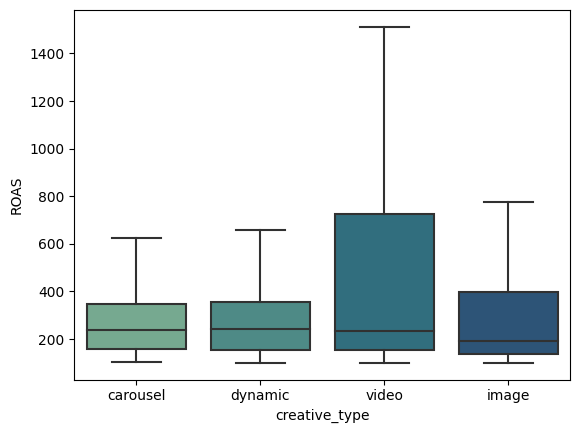

In [42]:
sns.boxplot(data=df, x='creative_type', y='ROAS', palette='crest', showfliers=False)

In [ ]:
df.groupby('creative_type').apply(lambda df: len(df)).sort_values()

creative_type
video        41
image        53
unknown     146
carousel    206
dynamic     293
dtype: int64

In [ ]:
df.groupby('creative_type')[['CTR', 'CR', 'CPM', 'ROAS']].median()

,CTR,CR,CPM,ROAS
creative_type,,,,
carousel,1.506241,2.465060,13.126569,241.480690
dynamic,1.019321,4.149378,17.199193,240.029077
image,1.204766,3.131115,17.924522,191.853288
unknown,1.459281,3.541241,25.218546,227.852374
video,1.412104,5.768164,22.121962,232.238071


In [ ]:
sns.boxplot()

In [25]:
discount_df = df[df.discount]
for text_type in TextType:
    discount_df[f"{text_type}_discounts"] = df[f"{text_type}"].apply(
        lambda texts: sum([get_discounts(text) for text in texts], [])
    )
discount_df["discounts"] = discount_df.apply(
    lambda row: sum([row[f"{text_type}_discounts"] for text_type in TextType], []), axis=1
)
discount_df["discount_values"] = discount_df["discounts"].apply(
    lambda discounts: [re.findall("\d+", discount)[0] for discount in discounts]
)
discount_df.discount_values.explode().astype(int).hist()
plt.show()

/tmp/ipykernel_47108/2930271971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discount_df["discounts"] = discount_df.apply(
/tmp/ipykernel_47108/2930271971.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discount_df["discount_values"] = discount_df["discounts"].apply(


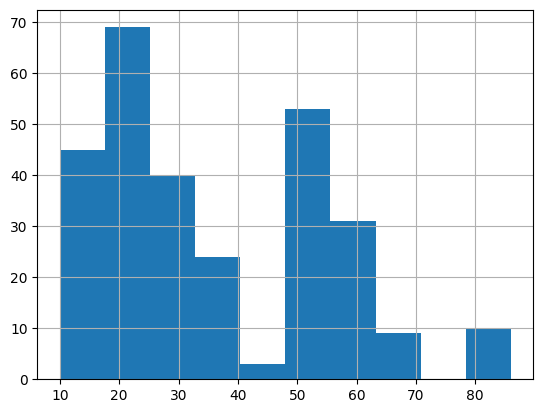

In [35]:
discount_df.discount_values.explode().astype(int).hist()
plt.show()

In [17]:
for link in df.preview_link:
    webbrowser.open(link)